# Poisson Process in Software Performance Engineering
## Hands-on Lecture

**Learning Objectives:**
- Implement a Poisson workload generator
- Validate statistical properties of the process
- Verify match with M/M/1 formulas through practical experiments

---

## Module 1: Review and Workload Generator

### 1.0 Poisson Process - Formal Definition

**Definition via Transition Probabilities**: A counting process $\{N(t), t \geq 0\}$ is a Poisson process with intensity $\lambda > 0$ if:

1. **Initial condition**: $N(0) = 0$

2. **Transition probabilities**: For any time interval $\tau > 0$, the probability of exactly $k$ events occurring is:

   $$P(N(t+\tau) - N(t) = k) = \frac{e^{-\lambda\tau} \cdot (\lambda\tau)^k}{k!}$$

   where $k = 0, 1, 2, \ldots$

**Key Properties:**
- **Stationary increments**: Probability depends only on interval length $\tau$, not on absolute time $t$
- **Independent increments**: Non-overlapping intervals are independent
- **Intensity $\lambda$**: Expected number of events per unit time
- **Memoryless**: Past events don't influence future probabilities

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize
import time
import pandas as pd

# Import our custom plotting functions
from poisson_plots import (
    plot_poisson_distribution, 
    plot_simulation_validation,
    print_poisson_statistics,
    print_simulation_comparison,
    simple_goodness_of_fit_test,
    two_sample_ks_test,
    visual_goodness_assessment,
    plot_lambda_effect_analysis,
    plot_exponential_interarrival_analysis,
    plot_mm1_utilization_effects
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

Poisson Process Transition Probabilities
Intensity λ = 3 events/second
Time interval τ = 2 seconds
Expected events in τ: λτ = 6


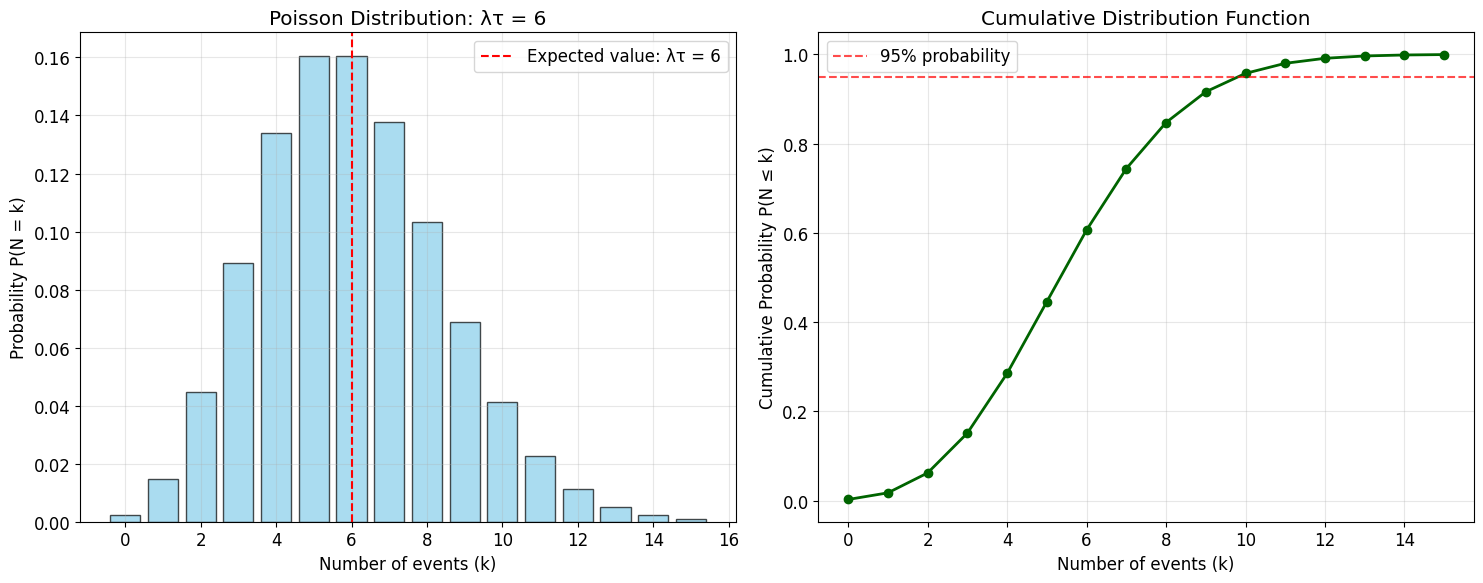


Key Statistics:
Sum of probabilities: 0.999491
Most likely outcome: 5 events
P(exactly 6 events): 0.1606
P(≤ 6 events): 0.6063

Most Significant Probabilities:
-----------------------------------
P(k =  1) = 0.0149 (1.5%)
P(k =  2) = 0.0446 (4.5%)
P(k =  3) = 0.0892 (8.9%)
P(k =  4) = 0.1339 (13.4%)
P(k =  5) = 0.1606 (16.1%)
P(k =  6) = 0.1606 (16.1%)
P(k =  7) = 0.1377 (13.8%)
P(k =  8) = 0.1033 (10.3%)
P(k =  9) = 0.0688 (6.9%)
P(k = 10) = 0.0413 (4.1%)
P(k = 11) = 0.0225 (2.3%)
P(k = 12) = 0.0113 (1.1%)


In [2]:
# Practical example of transition probabilities
lambda_rate = 3  # requests per second
tau = 2  # time interval in seconds

print("Poisson Process Transition Probabilities")
print("="*45)
print(f"Intensity λ = {lambda_rate} events/second")
print(f"Time interval τ = {tau} seconds")
print(f"Expected events in τ: λτ = {lambda_rate * tau}")

# Calculate theoretical probabilities using the transition probability formula
import math
k_values = range(16)
probabilities = []

for k in k_values:
    # P(N(t+τ) - N(t) = k) = e^(-λτ) * (λτ)^k / k!
    prob = math.exp(-lambda_rate * tau) * (lambda_rate * tau)**k / math.factorial(k)
    probabilities.append(prob)

# Visualize the theoretical distribution
plot_poisson_distribution(lambda_rate, tau, k_values, probabilities)

# Print key statistics
print_poisson_statistics(lambda_rate, tau, probabilities)

Validation of Theoretical Probabilities through Simulation
Running 50,000 simulations...


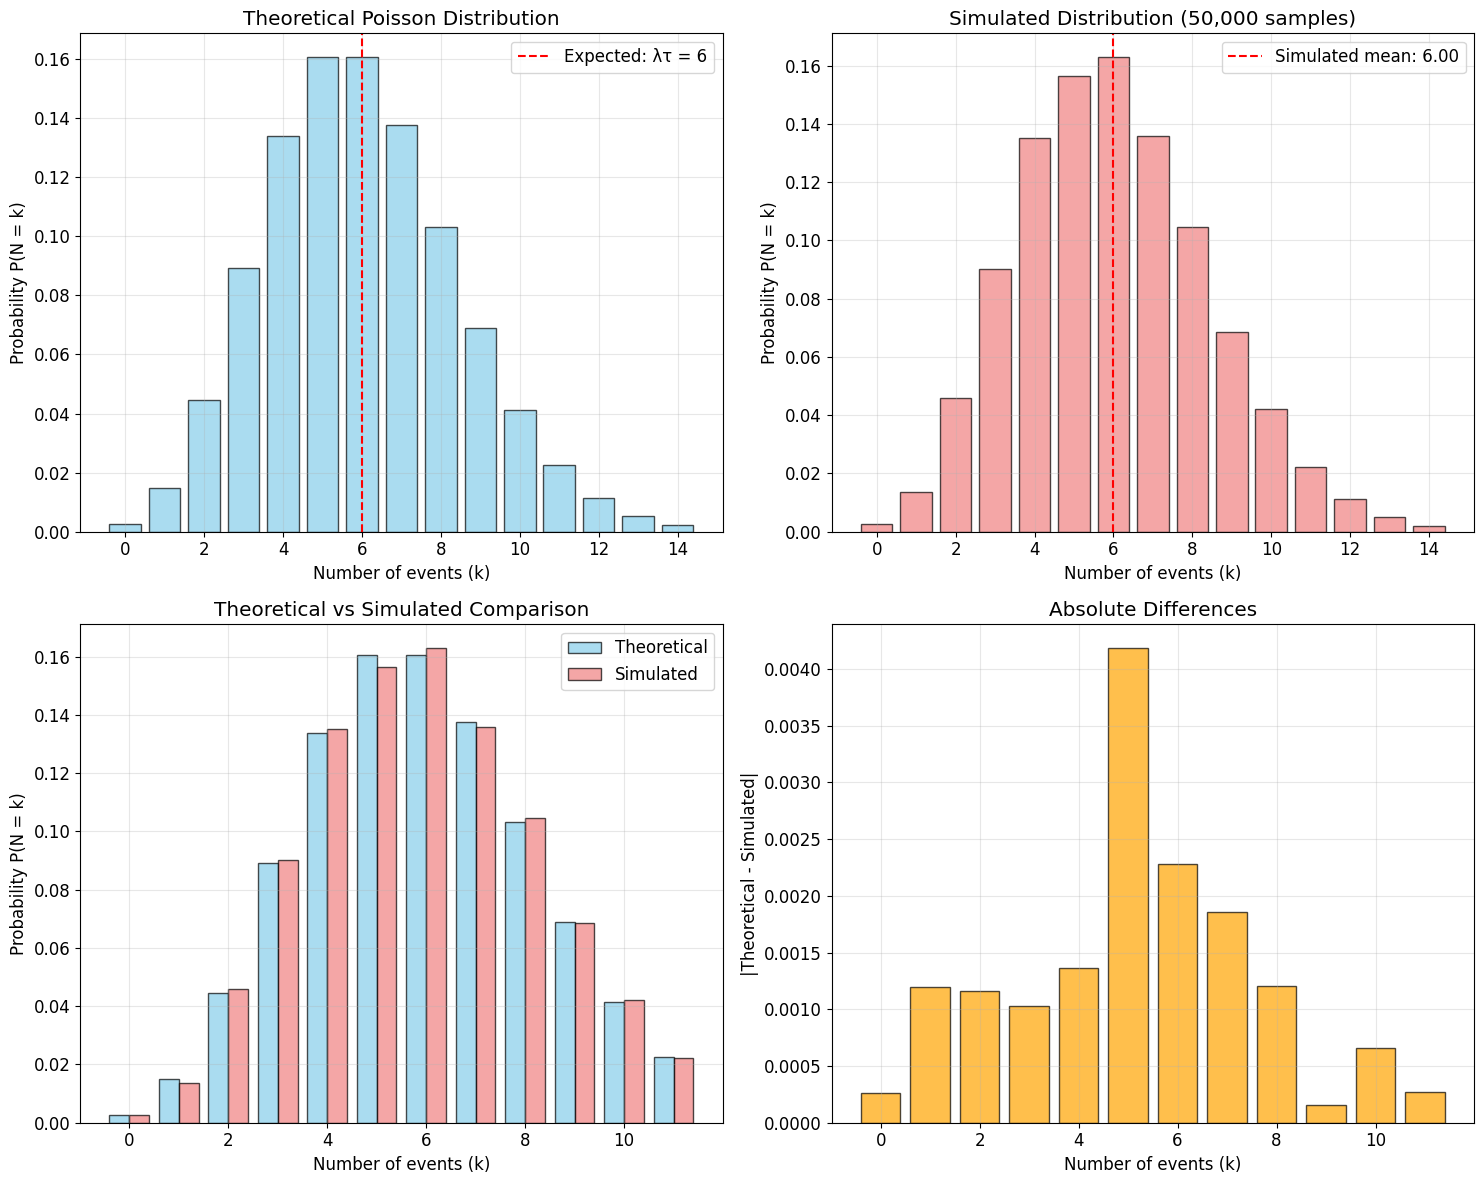


Statistical Summary:
Theoretical mean: 6.000
Simulated mean:   5.997
Theoretical std:  2.449
Simulated std:    2.448

Detailed Comparison:
-------------------------------------------------------
k   Theoretical  Simulated    Difference  
-------------------------------------------------------
1   0.0149       0.0137       0.0012      
2   0.0446       0.0458       0.0012      
3   0.0892       0.0903       0.0010      
4   0.1339       0.1352       0.0014      
5   0.1606       0.1564       0.0042      
6   0.1606       0.1629       0.0023      
7   0.1377       0.1358       0.0019      
8   0.1033       0.1045       0.0012      
9   0.0688       0.0687       0.0002      
10  0.0413       0.0420       0.0007      
11  0.0225       0.0223       0.0003      

Goodness of Fit Assessment:
-----------------------------------
Theoretical mean: 6.000
Simulated mean:   5.997
Mean error:       0.0%
Mean match:       ✓ PASS

Theoretical std:  2.449
Simulated std:    2.448
Std error:        0.0%

In [3]:
# Validation through simulation
print("Validation of Theoretical Probabilities through Simulation")
print("="*55)

n_simulations = 50000
simulated_counts = []

# Generate simulated data using inter-arrival times
print(f"Running {n_simulations:,} simulations...")
for _ in range(n_simulations):
    # Generate inter-arrival times until we exceed tau
    current_time = 0
    count = 0
    while True:
        inter_arrival = np.random.exponential(1/lambda_rate)
        if current_time + inter_arrival > tau:
            break
        current_time += inter_arrival
        count += 1
    simulated_counts.append(count)

# Create comparison visualization and get probability arrays
simulated_probs, extended_probs = plot_simulation_validation(
    lambda_rate, tau, probabilities, simulated_counts, n_simulations
)

# Print detailed comparison
print_simulation_comparison(lambda_rate, tau, simulated_counts, simulated_probs, extended_probs)

# Statistical validation using multiple approaches
simple_goodness_of_fit_test(simulated_counts, lambda_rate, tau)
two_sample_ks_test(simulated_counts, lambda_rate, tau)
max_diff, total_variation=visual_goodness_assessment(simulated_probs, extended_probs)

### 1.1 Parameter λ and Practical Meaning

The parameter **λ** (lambda) represents the **rate** or **intensity** of the process:
- λ = 5 means "5 events per unit time on average"
- In SPE context: "5 requests per second on average"
- Higher λ = more intense workload

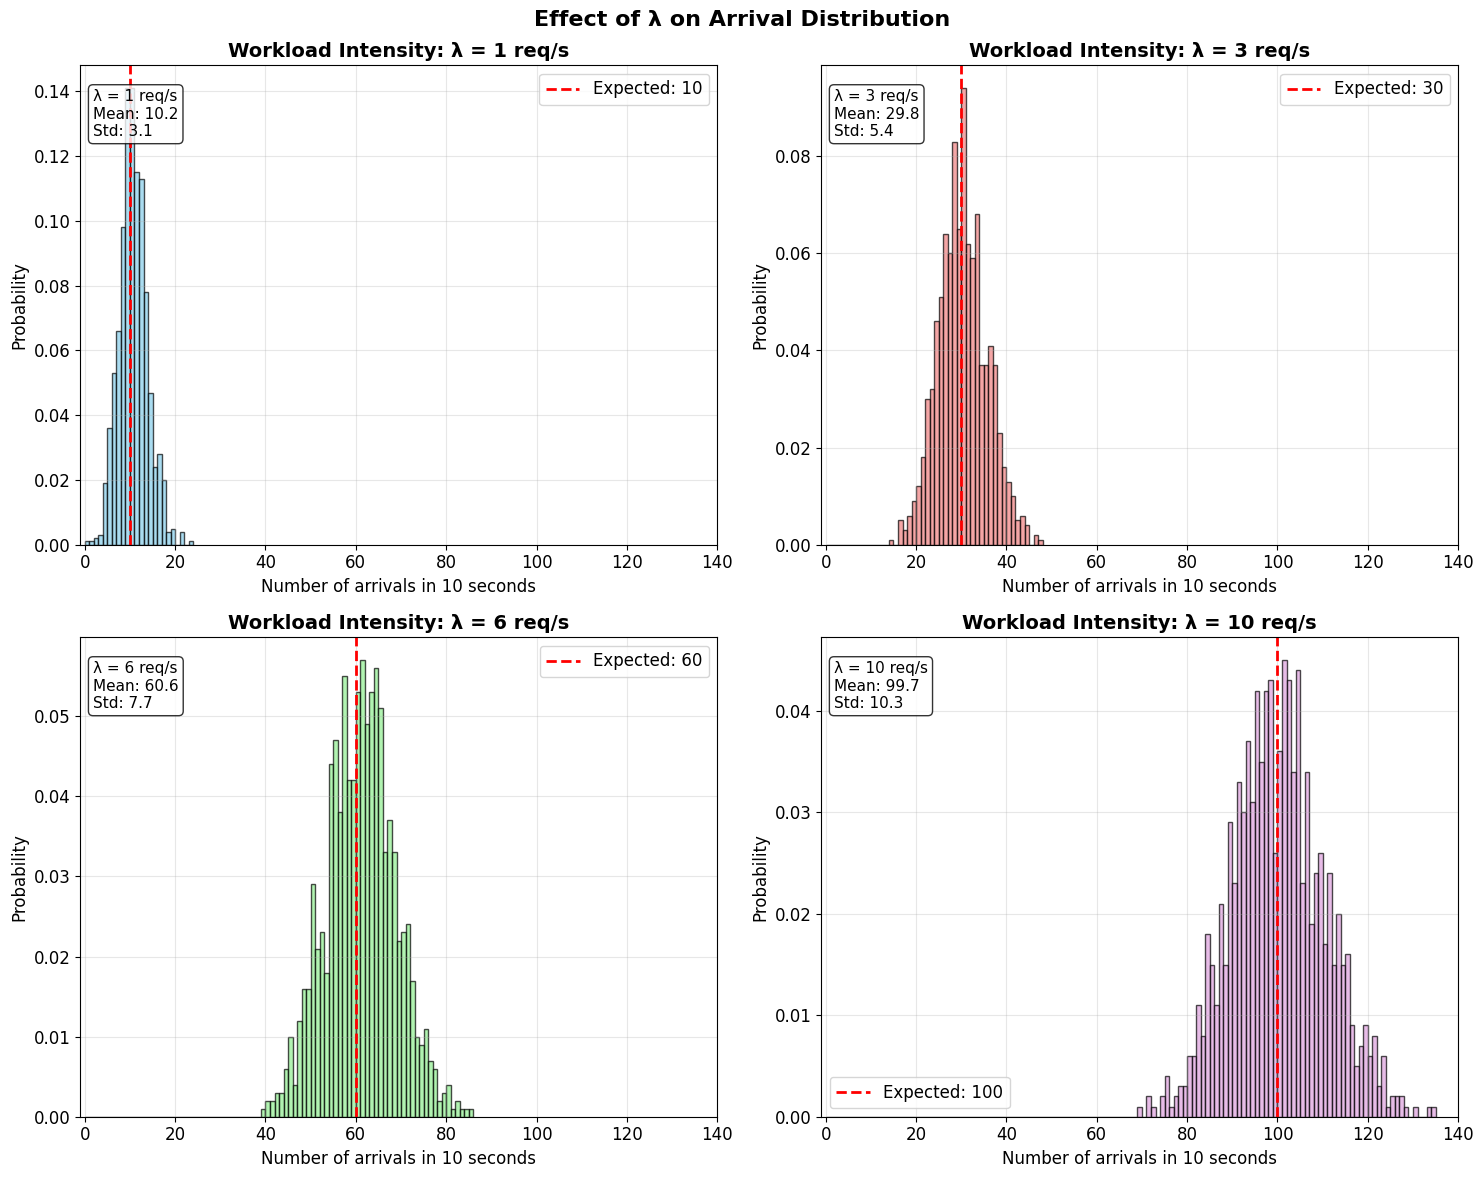

Workload Intensity Comparison:
λ (req/s)  Expected   Actual Mean  Std Dev    Spread    
---------------------------------------------
1          10         10.0         3.0        ±3.0      
3          30         30.2         5.2        ±5.2      
6          60         60.1         7.8        ±7.8      
10         100        99.9         10.0       ±10.0     

Key Observations:
• Higher λ → More arrivals on average
• Higher λ → Wider distribution (more variability)
• Higher λ → More intense workload for the system
• The distribution shape remains similar, just shifts and spreads


In [4]:
# Effect of λ parameter on arrival distributions
lambda_values = [1, 3, 6, 10]  # Different workload intensities
time_window = 10

# Visualize how λ affects the distribution of arrivals
plot_lambda_effect_analysis(lambda_values, time_window, n_samples=1000)

### 1.2 Exponential Inter-arrival Times

**Key Property**: If arrivals follow a Poisson process with rate λ, then the time between consecutive arrivals follows an **Exponential(λ)** distribution.

**Practical meaning**:
- Most requests arrive close together
- Few requests have large gaps between them
- Memoryless: knowing when the last request arrived doesn't help predict the next one

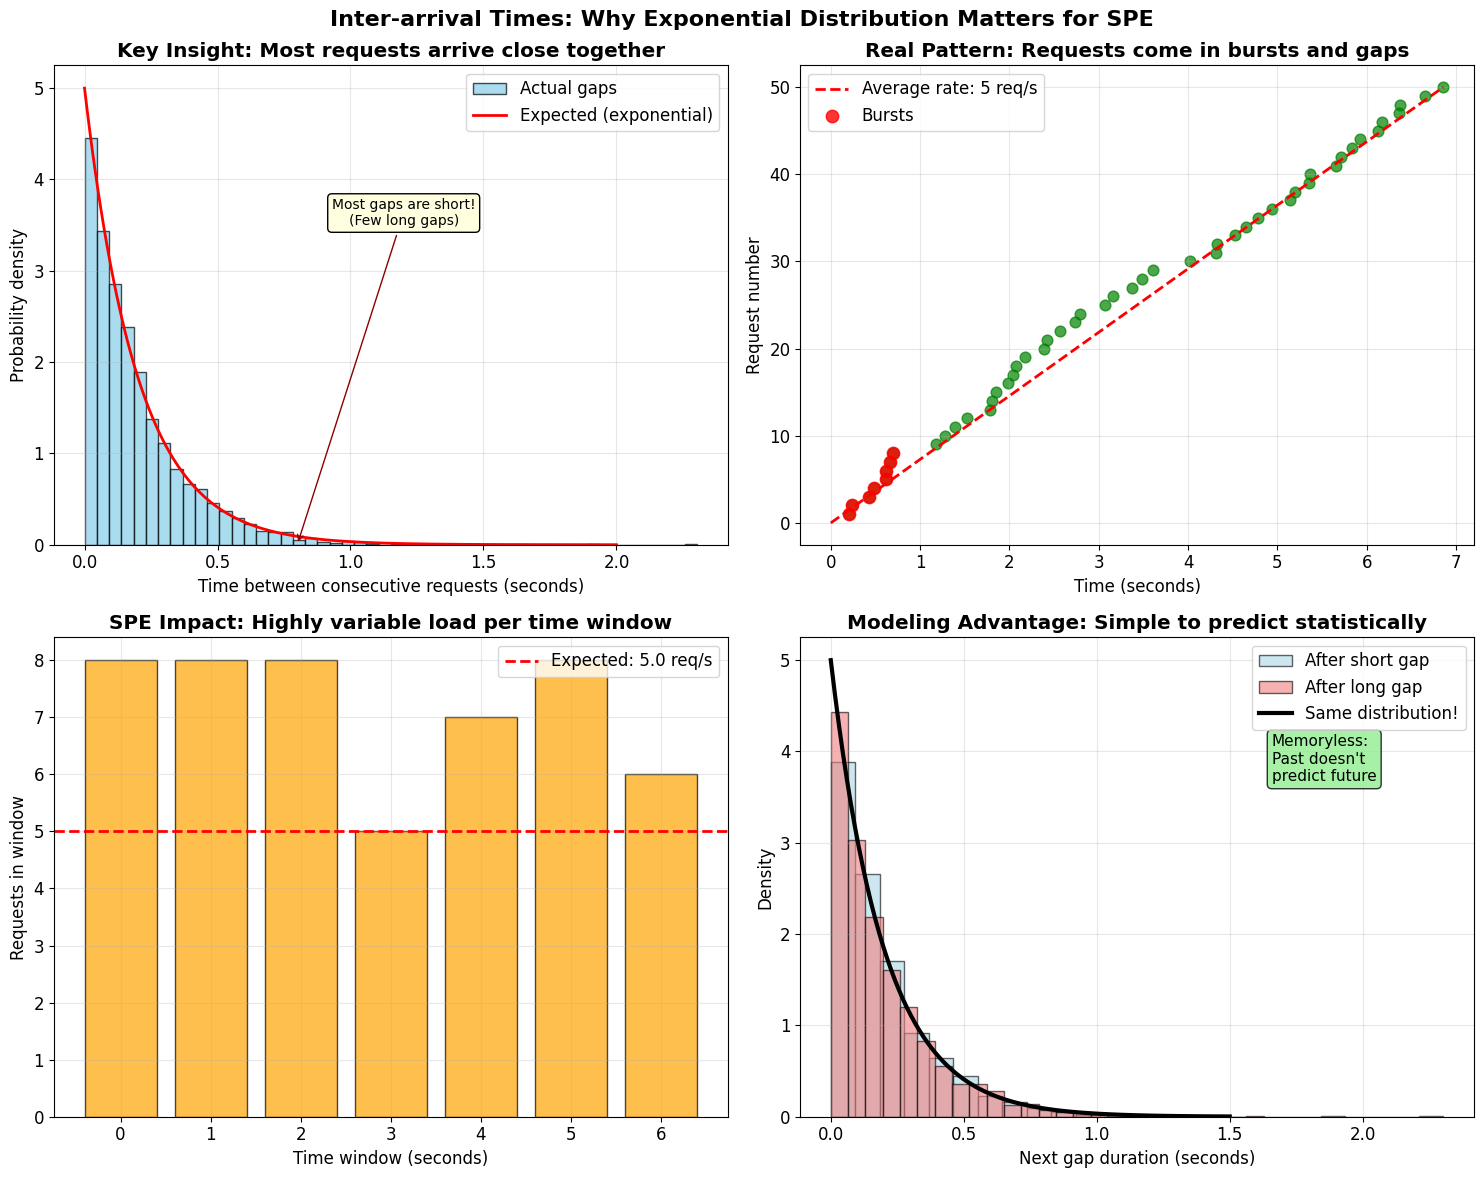

Key Insights for Software Performance Engineering:
1. TIMING PATTERN:
   • Average gap between requests: 0.20 seconds
   • But gaps are highly variable (CV = 0.99)
   • This creates bursty traffic patterns

2. LOAD VARIABILITY:
   • Expected requests per second: 5
   • But actual load varies significantly in short windows
   • Some seconds have many requests, others have none

3. MODELING BENEFITS:
   • Memoryless property simplifies analysis
   • Can predict system behavior statistically
   • Enables mathematical performance models (M/M/1)

4. VALIDATION:
   • Model fits real data: ✓ YES (p=0.669)
   • Memoryless property confirmed: ✓ YES

→ Conclusion: Exponential inter-arrivals are realistic for web traffic modeling


In [5]:
# Comprehensive analysis of exponential inter-arrival times
lambda_rate = 5  # requests per second
n_samples = 5000

# Generate comprehensive visualization and analysis
plot_exponential_interarrival_analysis(lambda_rate, n_samples)

### 1.3 Connection with M/M/1 Systems

**M/M/1 Queue**:
- **First M**: Markovian (Poisson) arrivals with rate λ
- **Second M**: Markovian (Exponential) service times with rate μ
- **1**: Single server

**Key Formulas** (we'll validate these experimentally):
- **Utilization**: ρ = λ/μ (must be < 1 for stability)
- **Expected response time**: E[T] = 1/(μ-λ)
- **Expected number in system**: E[N] = ρ/(1-ρ)
- **Expected queue length**: E[Nq] = ρ²/(1-ρ)

In [6]:
# M/M/1 theoretical predictions
lambda_rate = 5  # arrivals per second
mu_rate = 8      # service rate (requests per second)

# Check stability condition
rho = lambda_rate / mu_rate
print("M/M/1 System Parameters:")
print("="*30)
print(f"Arrival rate (λ): {lambda_rate} req/s")
print(f"Service rate (μ): {mu_rate} req/s")
print(f"Utilization (ρ):  {rho:.3f}")

if rho >= 1:
    print("⚠️  WARNING: System is unstable (ρ ≥ 1)!")
else:
    print("✅ System is stable (ρ < 1)")

# Calculate theoretical metrics
E_T = 1 / (mu_rate - lambda_rate)  # Expected response time
E_N = rho / (1 - rho)              # Expected number in system
E_Nq = (rho**2) / (1 - rho)        # Expected queue length
E_W = lambda_rate / (mu_rate * (mu_rate - lambda_rate))  # Expected waiting time

print("\nTheoretical Performance Metrics:")
print("="*35)
print(f"Expected response time: {E_T:.3f} seconds")
print(f"Expected number in system: {E_N:.3f}")
print(f"Expected queue length: {E_Nq:.3f}")
print(f"Expected waiting time: {E_W:.3f} seconds")

print("\nGoal: We'll validate these predictions using our Poisson generator!")

M/M/1 System Parameters:
Arrival rate (λ): 5 req/s
Service rate (μ): 8 req/s
Utilization (ρ):  0.625
✅ System is stable (ρ < 1)

Theoretical Performance Metrics:
Expected response time: 0.333 seconds
Expected number in system: 1.667
Expected queue length: 1.042
Expected waiting time: 0.208 seconds

Goal: We'll validate these predictions using our Poisson generator!


🎯 Key Message: Systems become extremely sensitive near capacity!


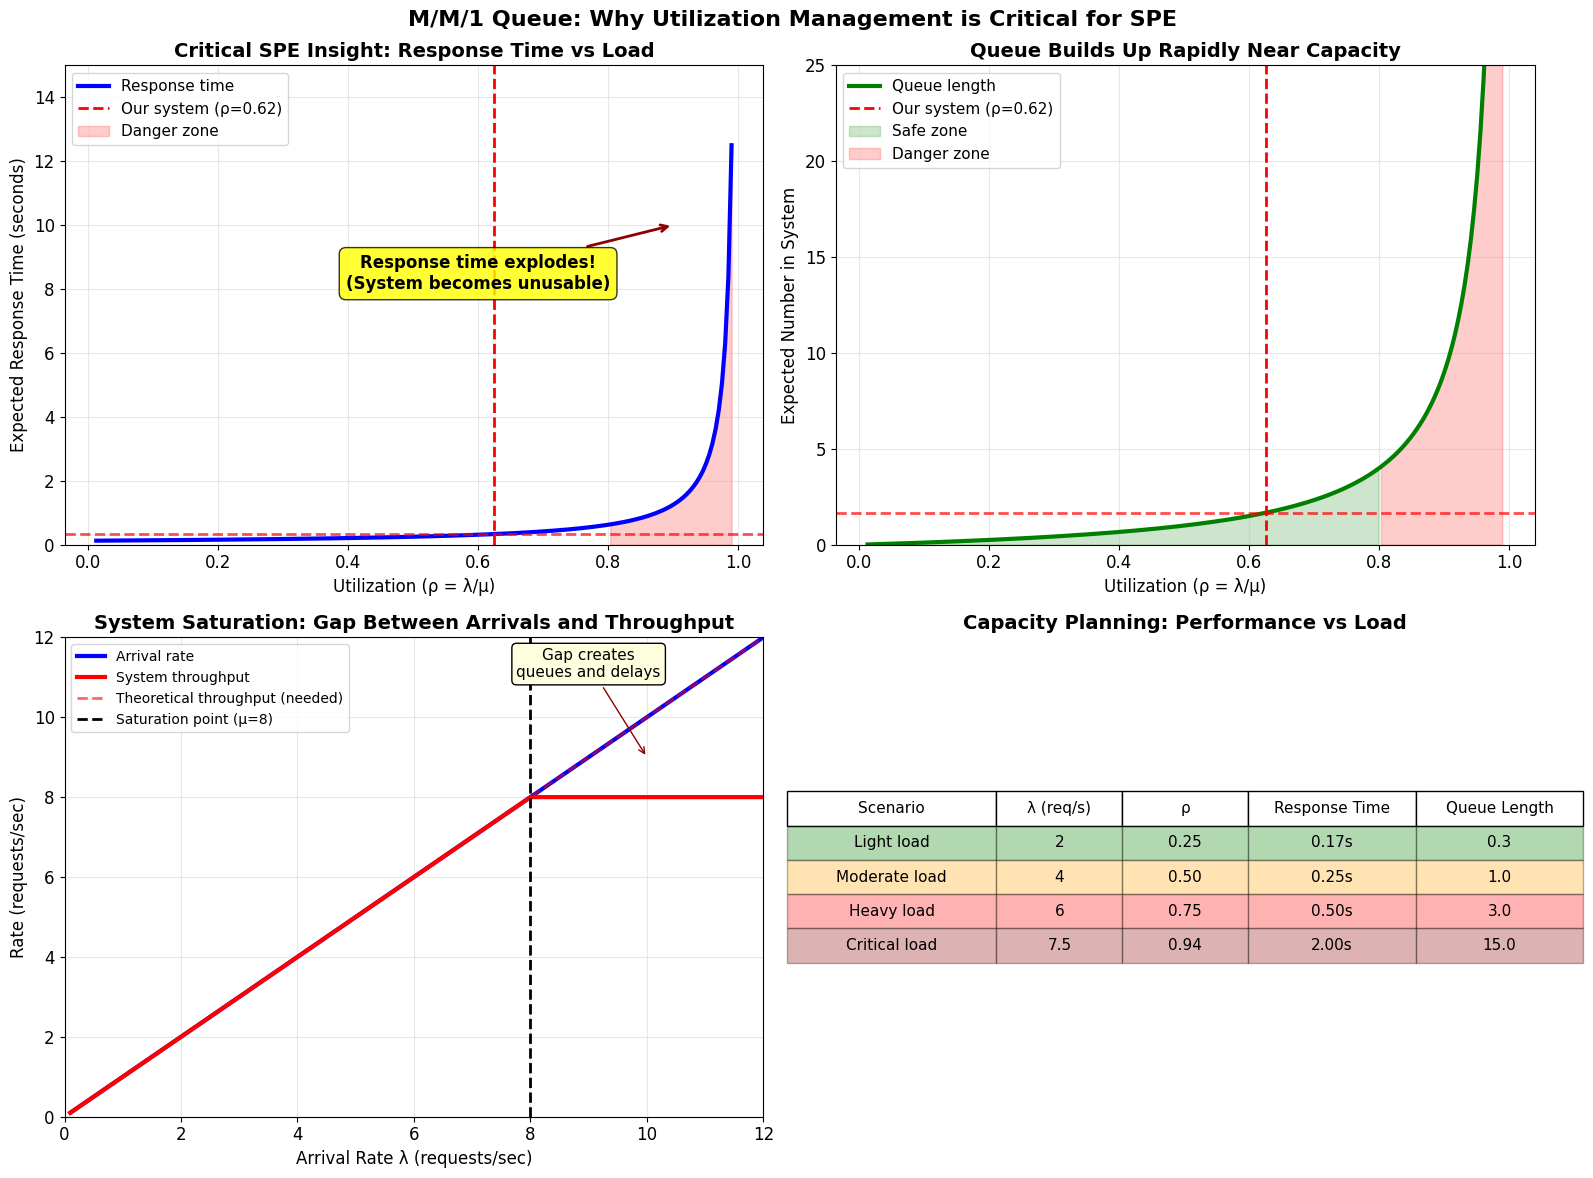

Critical Performance Engineering Insights:
CURRENT SYSTEM STATUS:
   • Arrival rate (λ): 5 req/s
   • Service rate (μ): 8 req/s
   • Utilization (ρ): 62.5%
   • Expected response time: 0.33 seconds
   • Expected queue length: 1.7 requests

CAPACITY PLANNING ASSESSMENT:
   Status: SAFE - System has good headroom

KEY THEORETICAL INSIGHTS:
   • Small load increases near capacity cause exponential performance degradation
   • Optimal utilization range: 70-80% for stable performance
   • Response time grows non-linearly with utilization
   • System throughput plateaus at service capacity (μ)


In [7]:
# Critical insight: How utilization affects M/M/1 system performance
lambda_rate = 5  # arrivals per second
mu_rate = 8      # service rate (requests per second)

print("🎯 Key Message: Systems become extremely sensitive near capacity!")
print("=" * 65)

# Visualize the dramatic non-linear relationship between load and performance
plot_mm1_utilization_effects(lambda_rate, mu_rate)

---
## Summary of Module 1 Review

**What we've established:**
1. **Poisson process**: Formal definition and key properties
2. **Parameter λ**: Controls workload intensity
3. **Inter-arrival times**: Follow exponential distribution
4. **M/M/1 connection**: Theoretical formulas to validate

**Next steps:**
- Implement robust Poisson workload generator
- Validate statistical properties experimentally
- Apply to M/M/1 system and verify theoretical predictions

---